In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
import shutil
import os
import warnings
import dnds_calculations as dnds

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
# # --- Read original fluxes to define bins ---
inputimage = "mosaic_image.fits"
catalog = inputimage.replace('.fits', '.pybdsf.srl.fits')

with fits.open(catalog) as hdul:
    orig_data = hdul[1].data
original_fluxes = np.array(orig_data['Total_flux'])

bins = 11
min_flux_cut = 0.02 # Jy
flux_bins, bin_centers, counts, bin_edges, bin_widths = dnds.compute_histogram(original_fluxes, bins, min_flux_cut)
flux_min, flux_max = flux_bins[0], flux_bins[-1]

# FDR 

In [3]:

negative_fits = "negative_image.fits"
negative_catalog = negative_fits.replace(".fits", ".pybdsf.srl.fits")

dnds.invert_fits_image(inputimage, negative_fits)
dnds.run_pybdsf_neg(negative_fits)
negative_fluxes = dnds.read_pybdsf_catalog(negative_catalog)

cat_counts, _ = np.histogram(original_fluxes, bins=flux_bins)
neg_counts, _ = np.histogram(negative_fluxes, bins=flux_bins)

fdr = np.divide(neg_counts, cat_counts, out=np.zeros_like(neg_counts, dtype=float), where=(cat_counts) > 0)
fdr_correction = np.maximum(1 - fdr, 0.01) # correction factor to be divided with in the code. 
np.save('fdr_correction.npy',fdr_correction)

print(fdr_correction)

Inverted FITS image saved to negative_image.fits


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'negative_image.pybdsf.srl.fits'
[0.99193548 0.98648649 0.99212598 1.         1.         1.
 1.         1.         1.         1.        ]


# completeness

In [4]:
residual_image = inputimage.replace('.fits', '.pybdsf_gaus_resid.fits') 
modified_image = "modified_residual.fits"
output_npz = 'completeness_corrections.npz'

In [5]:
# --- Generate valid RA/Dec grid from input/residual image ---
with fits.open(inputimage, mode='readonly') as hdu:
    header = hdu[0].header
    wcs = WCS(header, naxis=2)
    data = hdu[0].data.astype(np.float64)

if data.ndim == 4:
    base_data = data[0, 0]
elif data.ndim == 3:
    base_data = data[0]
elif data.ndim == 2:
    base_data = data
else:
    raise ValueError(f"Unexpected FITS dimensions: {data.shape}")

valid_pixels = np.argwhere(~np.isnan(base_data))
valid_ra, valid_dec = wcs.all_pix2world(valid_pixels[:, 1], valid_pixels[:, 0], 0)


Set OBSGEO-B to    19.090653 from OBSGEO-[XYZ].
Set OBSGEO-H to      636.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [6]:
# --- Simulation parameters ---
NN = 100  # number of realizations
seeds = np.random.RandomState(42).randint(1, 1000, size=NN)
extended_fraction = 0.26

# array declarations
counts_recovered = np.zeros((NN, bins-1))
counts_injected = np.zeros((NN, bins-1))


num_sources = np.sum(counts)

for i in range(NN):
    print(f"Iteration {i+1}/{NN}")
    
    # generate mock fluxes
    flux_dens, is_ext = dnds.generate_mock_sources(num_sources, flux_min, flux_max, extended_fraction, seed=seeds[i])
    is_ext = np.random.rand(len(flux_dens)) < extended_fraction

    # Record injected counts
    counts_injected[i], _ = np.histogram(flux_dens, bins=flux_bins)

    # Create synthetic catalog
    inj_flux, inj_ra, inj_dec = dnds.generate_synthetic_catalog(
        catalog, 'synthetic.vot', flux_dens, is_ext, valid_ra, valid_dec, seed=seeds[i]
    )

    # Reset residual image
    shutil.copy(residual_image, modified_image)

    # Inject and recover
    os.system(f"AeRes --add -c synthetic.vot -f {residual_image} -r {modified_image}")
    dnds.run_pybdsf(modified_image)

    # Read recovered catalog
    with fits.open(modified_image.replace('.fits', '.pybdsf.srl.fits')) as hd:
        rec = hd[1].data
        # rec_flux = np.array(rec['Total_flux'])
        rec_ra = np.array(rec['RA'])
        rec_dec = np.array(rec['DEC'])

    # Match
    inj_idx, rec_idx = dnds.match_recovered_sources(inj_ra, inj_dec, rec_ra, rec_dec)

    # Histogram matched injected fluxes
    matched_inj_flux = inj_flux[inj_idx]
    counts_recovered[i], _ = np.histogram(matched_inj_flux, bins=flux_bins)


Iteration 1/100
Generated 598 synthetic sources


502764:INFO This is AeRes v0.2.7-(2020-07-30)
502764:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
502764:INFO Reading file synthetic.vot
502764:INFO read 598 sources from synthetic.vot
502764:INFO modeled 598 sources
502764:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 2/100
Generated 598 synthetic sources


504037:INFO This is AeRes v0.2.7-(2020-07-30)
504037:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
504037:INFO Reading file synthetic.vot
504037:INFO read 598 sources from synthetic.vot
504037:INFO modeled 598 sources
504037:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 3/100
Generated 598 synthetic sources


505273:INFO This is AeRes v0.2.7-(2020-07-30)
505273:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
505273:INFO Reading file synthetic.vot
505273:INFO read 598 sources from synthetic.vot
505273:INFO modeled 598 sources
505273:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 4/100
Generated 598 synthetic sources


506509:INFO This is AeRes v0.2.7-(2020-07-30)
506509:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
506509:INFO Reading file synthetic.vot
506509:INFO read 598 sources from synthetic.vot
506509:INFO modeled 598 sources
506509:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 5/100
Generated 598 synthetic sources


507733:INFO This is AeRes v0.2.7-(2020-07-30)
507733:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
507733:INFO Reading file synthetic.vot
507733:INFO read 598 sources from synthetic.vot
507733:INFO modeled 598 sources
507733:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 6/100
Generated 598 synthetic sources


508961:INFO This is AeRes v0.2.7-(2020-07-30)
508961:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
508961:INFO Reading file synthetic.vot
508961:INFO read 598 sources from synthetic.vot
508961:INFO modeled 598 sources
508961:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 7/100
Generated 598 synthetic sources


510197:INFO This is AeRes v0.2.7-(2020-07-30)
510197:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
510197:INFO Reading file synthetic.vot
510197:INFO read 598 sources from synthetic.vot
510197:INFO modeled 598 sources
510197:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 8/100
Generated 598 synthetic sources


511413:INFO This is AeRes v0.2.7-(2020-07-30)
511413:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
511413:INFO Reading file synthetic.vot
511413:INFO read 598 sources from synthetic.vot
511413:INFO modeled 598 sources
511413:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 9/100
Generated 598 synthetic sources


512650:INFO This is AeRes v0.2.7-(2020-07-30)
512650:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
512650:INFO Reading file synthetic.vot
512650:INFO read 598 sources from synthetic.vot
512650:INFO modeled 598 sources
512650:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 10/100
Generated 598 synthetic sources


513900:INFO This is AeRes v0.2.7-(2020-07-30)
513900:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
513900:INFO Reading file synthetic.vot
513900:INFO read 598 sources from synthetic.vot
513900:INFO modeled 598 sources
513900:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 11/100
Generated 598 synthetic sources


515132:INFO This is AeRes v0.2.7-(2020-07-30)
515132:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
515132:INFO Reading file synthetic.vot
515132:INFO read 598 sources from synthetic.vot
515132:INFO modeled 598 sources
515132:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 12/100
Generated 598 synthetic sources


516360:INFO This is AeRes v0.2.7-(2020-07-30)
516360:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
516360:INFO Reading file synthetic.vot
516360:INFO read 598 sources from synthetic.vot
516360:INFO modeled 598 sources
516360:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 13/100
Generated 598 synthetic sources


517574:INFO This is AeRes v0.2.7-(2020-07-30)
517574:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
517574:INFO Reading file synthetic.vot
517574:INFO read 598 sources from synthetic.vot
517574:INFO modeled 598 sources
517574:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 14/100
Generated 598 synthetic sources


518805:INFO This is AeRes v0.2.7-(2020-07-30)
518805:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
518805:INFO Reading file synthetic.vot
518805:INFO read 598 sources from synthetic.vot
518805:INFO modeled 598 sources
518805:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 15/100
Generated 598 synthetic sources


520027:INFO This is AeRes v0.2.7-(2020-07-30)
520027:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
520027:INFO Reading file synthetic.vot
520027:INFO read 598 sources from synthetic.vot
520027:INFO modeled 598 sources
520027:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 16/100
Generated 598 synthetic sources


521246:INFO This is AeRes v0.2.7-(2020-07-30)
521246:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
521246:INFO Reading file synthetic.vot
521246:INFO read 598 sources from synthetic.vot
521246:INFO modeled 598 sources
521246:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 17/100
Generated 598 synthetic sources


522462:INFO This is AeRes v0.2.7-(2020-07-30)
522462:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
522462:INFO Reading file synthetic.vot
522462:INFO read 598 sources from synthetic.vot
522462:INFO modeled 598 sources
522462:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 18/100
Generated 598 synthetic sources


523688:INFO This is AeRes v0.2.7-(2020-07-30)
523688:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
523688:INFO Reading file synthetic.vot
523688:INFO read 598 sources from synthetic.vot
523688:INFO modeled 598 sources
523688:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 19/100
Generated 598 synthetic sources


524961:INFO This is AeRes v0.2.7-(2020-07-30)
524961:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
524961:INFO Reading file synthetic.vot
524961:INFO read 598 sources from synthetic.vot
524961:INFO modeled 598 sources
524961:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 20/100
Generated 598 synthetic sources


526211:INFO This is AeRes v0.2.7-(2020-07-30)
526211:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
526211:INFO Reading file synthetic.vot
526211:INFO read 598 sources from synthetic.vot
526211:INFO modeled 598 sources
526211:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 21/100
Generated 598 synthetic sources


527427:INFO This is AeRes v0.2.7-(2020-07-30)
527427:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
527427:INFO Reading file synthetic.vot
527427:INFO read 598 sources from synthetic.vot
527427:INFO modeled 598 sources
527427:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 22/100
Generated 598 synthetic sources


528652:INFO This is AeRes v0.2.7-(2020-07-30)
528652:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
528652:INFO Reading file synthetic.vot
528652:INFO read 598 sources from synthetic.vot
528652:INFO modeled 598 sources
528652:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 23/100
Generated 598 synthetic sources


529872:INFO This is AeRes v0.2.7-(2020-07-30)
529872:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
529872:INFO Reading file synthetic.vot
529872:INFO read 598 sources from synthetic.vot
529872:INFO modeled 598 sources
529872:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 24/100
Generated 598 synthetic sources


531100:INFO This is AeRes v0.2.7-(2020-07-30)
531100:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
531100:INFO Reading file synthetic.vot
531100:INFO read 598 sources from synthetic.vot
531100:INFO modeled 598 sources
531100:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 25/100
Generated 598 synthetic sources


532322:INFO This is AeRes v0.2.7-(2020-07-30)
532322:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
532322:INFO Reading file synthetic.vot
532322:INFO read 598 sources from synthetic.vot
532322:INFO modeled 598 sources
532322:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 26/100
Generated 598 synthetic sources


533544:INFO This is AeRes v0.2.7-(2020-07-30)
533544:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
533544:INFO Reading file synthetic.vot
533544:INFO read 598 sources from synthetic.vot
533544:INFO modeled 598 sources
533544:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 27/100
Generated 598 synthetic sources


534810:INFO This is AeRes v0.2.7-(2020-07-30)
534810:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
534810:INFO Reading file synthetic.vot
534810:INFO read 598 sources from synthetic.vot
534810:INFO modeled 598 sources
534810:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 28/100
Generated 598 synthetic sources


536040:INFO This is AeRes v0.2.7-(2020-07-30)
536040:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
536040:INFO Reading file synthetic.vot
536040:INFO read 598 sources from synthetic.vot
536040:INFO modeled 598 sources
536040:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 29/100
Generated 598 synthetic sources


537269:INFO This is AeRes v0.2.7-(2020-07-30)
537269:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
537269:INFO Reading file synthetic.vot
537269:INFO read 598 sources from synthetic.vot
537269:INFO modeled 598 sources
537269:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 30/100
Generated 598 synthetic sources


538496:INFO This is AeRes v0.2.7-(2020-07-30)
538496:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
538496:INFO Reading file synthetic.vot
538496:INFO read 598 sources from synthetic.vot
538496:INFO modeled 598 sources
538496:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 31/100
Generated 598 synthetic sources


539718:INFO This is AeRes v0.2.7-(2020-07-30)
539718:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
539718:INFO Reading file synthetic.vot
539718:INFO read 598 sources from synthetic.vot
539718:INFO modeled 598 sources
539718:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 32/100
Generated 598 synthetic sources


540942:INFO This is AeRes v0.2.7-(2020-07-30)
540942:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
540942:INFO Reading file synthetic.vot
540942:INFO read 598 sources from synthetic.vot
540942:INFO modeled 598 sources
540942:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 33/100
Generated 598 synthetic sources


542153:INFO This is AeRes v0.2.7-(2020-07-30)
542153:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
542153:INFO Reading file synthetic.vot
542153:INFO read 598 sources from synthetic.vot
542153:INFO modeled 598 sources
542153:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 34/100
Generated 598 synthetic sources


543381:INFO This is AeRes v0.2.7-(2020-07-30)
543381:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
543381:INFO Reading file synthetic.vot
543381:INFO read 598 sources from synthetic.vot
543381:INFO modeled 598 sources
543381:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 35/100
Generated 598 synthetic sources


544606:INFO This is AeRes v0.2.7-(2020-07-30)
544606:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
544606:INFO Reading file synthetic.vot
544606:INFO read 598 sources from synthetic.vot
544606:INFO modeled 598 sources
544606:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 36/100
Generated 598 synthetic sources


545886:INFO This is AeRes v0.2.7-(2020-07-30)
545886:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
545886:INFO Reading file synthetic.vot
545886:INFO read 598 sources from synthetic.vot
545886:INFO modeled 598 sources
545886:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 37/100
Generated 598 synthetic sources


547101:INFO This is AeRes v0.2.7-(2020-07-30)
547101:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
547101:INFO Reading file synthetic.vot
547101:INFO read 598 sources from synthetic.vot
547101:INFO modeled 598 sources
547101:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 38/100
Generated 598 synthetic sources


548319:INFO This is AeRes v0.2.7-(2020-07-30)
548319:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
548319:INFO Reading file synthetic.vot
548319:INFO read 598 sources from synthetic.vot
548319:INFO modeled 598 sources
548319:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 39/100
Generated 598 synthetic sources


549553:INFO This is AeRes v0.2.7-(2020-07-30)
549553:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
549553:INFO Reading file synthetic.vot
549553:INFO read 598 sources from synthetic.vot
549553:INFO modeled 598 sources
549553:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 40/100
Generated 598 synthetic sources


550773:INFO This is AeRes v0.2.7-(2020-07-30)
550773:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
550773:INFO Reading file synthetic.vot
550773:INFO read 598 sources from synthetic.vot
550773:INFO modeled 598 sources
550773:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 41/100
Generated 598 synthetic sources


551989:INFO This is AeRes v0.2.7-(2020-07-30)
551989:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
551989:INFO Reading file synthetic.vot
551989:INFO read 598 sources from synthetic.vot
551989:INFO modeled 598 sources
551989:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 42/100
Generated 598 synthetic sources


553209:INFO This is AeRes v0.2.7-(2020-07-30)
553209:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
553209:INFO Reading file synthetic.vot
553209:INFO read 598 sources from synthetic.vot
553209:INFO modeled 598 sources
553209:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 43/100
Generated 598 synthetic sources


554430:INFO This is AeRes v0.2.7-(2020-07-30)
554430:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
554430:INFO Reading file synthetic.vot
554430:INFO read 598 sources from synthetic.vot
554430:INFO modeled 598 sources
554430:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 44/100
Generated 598 synthetic sources


555690:INFO This is AeRes v0.2.7-(2020-07-30)
555690:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
555690:INFO Reading file synthetic.vot
555690:INFO read 598 sources from synthetic.vot
555690:INFO modeled 598 sources
555690:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 45/100
Generated 598 synthetic sources


556925:INFO This is AeRes v0.2.7-(2020-07-30)
556925:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
556925:INFO Reading file synthetic.vot
556925:INFO read 598 sources from synthetic.vot
556925:INFO modeled 598 sources
556925:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 46/100
Generated 598 synthetic sources


558145:INFO This is AeRes v0.2.7-(2020-07-30)
558145:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
558145:INFO Reading file synthetic.vot
558145:INFO read 598 sources from synthetic.vot
558145:INFO modeled 598 sources
558145:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 47/100
Generated 598 synthetic sources


559363:INFO This is AeRes v0.2.7-(2020-07-30)
559363:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
559363:INFO Reading file synthetic.vot
559363:INFO read 598 sources from synthetic.vot
559363:INFO modeled 598 sources
559363:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 48/100
Generated 598 synthetic sources


560579:INFO This is AeRes v0.2.7-(2020-07-30)
560579:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
560579:INFO Reading file synthetic.vot
560579:INFO read 598 sources from synthetic.vot
560579:INFO modeled 598 sources
560579:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 49/100
Generated 598 synthetic sources


561816:INFO This is AeRes v0.2.7-(2020-07-30)
561816:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
561816:INFO Reading file synthetic.vot
561816:INFO read 598 sources from synthetic.vot
561816:INFO modeled 598 sources
561816:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 50/100
Generated 598 synthetic sources


563040:INFO This is AeRes v0.2.7-(2020-07-30)
563040:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
563040:INFO Reading file synthetic.vot
563040:INFO read 598 sources from synthetic.vot
563040:INFO modeled 598 sources
563040:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 51/100
Generated 598 synthetic sources


564266:INFO This is AeRes v0.2.7-(2020-07-30)
564266:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
564266:INFO Reading file synthetic.vot
564266:INFO read 598 sources from synthetic.vot
564266:INFO modeled 598 sources
564266:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 52/100
Generated 598 synthetic sources


565526:INFO This is AeRes v0.2.7-(2020-07-30)
565526:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
565526:INFO Reading file synthetic.vot
565526:INFO read 598 sources from synthetic.vot
565526:INFO modeled 598 sources
565526:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 53/100
Generated 598 synthetic sources


566764:INFO This is AeRes v0.2.7-(2020-07-30)
566764:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
566764:INFO Reading file synthetic.vot
566764:INFO read 598 sources from synthetic.vot
566764:INFO modeled 598 sources
566764:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 54/100
Generated 598 synthetic sources


568007:INFO This is AeRes v0.2.7-(2020-07-30)
568007:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
568007:INFO Reading file synthetic.vot
568007:INFO read 598 sources from synthetic.vot
568007:INFO modeled 598 sources
568007:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 55/100
Generated 598 synthetic sources


569401:INFO This is AeRes v0.2.7-(2020-07-30)
569401:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
569401:INFO Reading file synthetic.vot
569401:INFO read 598 sources from synthetic.vot
569401:INFO modeled 598 sources
569401:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 56/100
Generated 598 synthetic sources


570628:INFO This is AeRes v0.2.7-(2020-07-30)
570628:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
570628:INFO Reading file synthetic.vot
570628:INFO read 598 sources from synthetic.vot
570628:INFO modeled 598 sources
570628:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 57/100
Generated 598 synthetic sources


572026:INFO This is AeRes v0.2.7-(2020-07-30)
572026:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
572026:INFO Reading file synthetic.vot
572026:INFO read 598 sources from synthetic.vot
572026:INFO modeled 598 sources
572026:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 58/100
Generated 598 synthetic sources


573252:INFO This is AeRes v0.2.7-(2020-07-30)
573252:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
573252:INFO Reading file synthetic.vot
573252:INFO read 598 sources from synthetic.vot
573252:INFO modeled 598 sources
573252:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 59/100
Generated 598 synthetic sources


574484:INFO This is AeRes v0.2.7-(2020-07-30)
574484:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
574484:INFO Reading file synthetic.vot
574484:INFO read 598 sources from synthetic.vot
574484:INFO modeled 598 sources
574484:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 60/100
Generated 598 synthetic sources


575740:INFO This is AeRes v0.2.7-(2020-07-30)
575740:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
575740:INFO Reading file synthetic.vot
575740:INFO read 598 sources from synthetic.vot
575740:INFO modeled 598 sources
575740:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 61/100
Generated 598 synthetic sources


577001:INFO This is AeRes v0.2.7-(2020-07-30)
577001:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
577001:INFO Reading file synthetic.vot
577001:INFO read 598 sources from synthetic.vot
577001:INFO modeled 598 sources
577001:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 62/100
Generated 598 synthetic sources


578265:INFO This is AeRes v0.2.7-(2020-07-30)
578265:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
578265:INFO Reading file synthetic.vot
578265:INFO read 598 sources from synthetic.vot
578265:INFO modeled 598 sources
578265:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 63/100
Generated 598 synthetic sources


579506:INFO This is AeRes v0.2.7-(2020-07-30)
579506:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
579506:INFO Reading file synthetic.vot
579506:INFO read 598 sources from synthetic.vot
579506:INFO modeled 598 sources
579506:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 64/100
Generated 598 synthetic sources


580721:INFO This is AeRes v0.2.7-(2020-07-30)
580721:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
580721:INFO Reading file synthetic.vot
580721:INFO read 598 sources from synthetic.vot
580721:INFO modeled 598 sources
580721:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 65/100
Generated 598 synthetic sources


581939:INFO This is AeRes v0.2.7-(2020-07-30)
581939:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
581939:INFO Reading file synthetic.vot
581939:INFO read 598 sources from synthetic.vot
581939:INFO modeled 598 sources
581939:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 66/100
Generated 598 synthetic sources


583848:INFO This is AeRes v0.2.7-(2020-07-30)
583848:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
583848:INFO Reading file synthetic.vot
583848:INFO read 598 sources from synthetic.vot
583848:INFO modeled 598 sources
583848:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 67/100
Generated 598 synthetic sources


585062:INFO This is AeRes v0.2.7-(2020-07-30)
585062:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
585062:INFO Reading file synthetic.vot
585062:INFO read 598 sources from synthetic.vot
585062:INFO modeled 598 sources
585062:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 68/100
Generated 598 synthetic sources


586326:INFO This is AeRes v0.2.7-(2020-07-30)
586326:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
586326:INFO Reading file synthetic.vot
586326:INFO read 598 sources from synthetic.vot
586326:INFO modeled 598 sources
586326:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 69/100
Generated 598 synthetic sources


587556:INFO This is AeRes v0.2.7-(2020-07-30)
587556:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
587556:INFO Reading file synthetic.vot
587556:INFO read 598 sources from synthetic.vot
587556:INFO modeled 598 sources
587556:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 70/100
Generated 598 synthetic sources


588772:INFO This is AeRes v0.2.7-(2020-07-30)
588772:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
588772:INFO Reading file synthetic.vot
588772:INFO read 598 sources from synthetic.vot
588772:INFO modeled 598 sources
588772:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 71/100
Generated 598 synthetic sources


590079:INFO This is AeRes v0.2.7-(2020-07-30)
590079:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
590079:INFO Reading file synthetic.vot
590079:INFO read 598 sources from synthetic.vot
590079:INFO modeled 598 sources
590079:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 72/100
Generated 598 synthetic sources


591309:INFO This is AeRes v0.2.7-(2020-07-30)
591309:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
591309:INFO Reading file synthetic.vot
591309:INFO read 598 sources from synthetic.vot
591309:INFO modeled 598 sources
591309:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 73/100
Generated 598 synthetic sources


592578:INFO This is AeRes v0.2.7-(2020-07-30)
592578:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
592578:INFO Reading file synthetic.vot
592578:INFO read 598 sources from synthetic.vot
592578:INFO modeled 598 sources
592578:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 74/100
Generated 598 synthetic sources


593812:INFO This is AeRes v0.2.7-(2020-07-30)
593812:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
593812:INFO Reading file synthetic.vot
593812:INFO read 598 sources from synthetic.vot
593812:INFO modeled 598 sources
593812:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 75/100
Generated 598 synthetic sources


595178:INFO This is AeRes v0.2.7-(2020-07-30)
595178:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
595178:INFO Reading file synthetic.vot
595178:INFO read 598 sources from synthetic.vot
595178:INFO modeled 598 sources
595178:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 76/100
Generated 598 synthetic sources


596471:INFO This is AeRes v0.2.7-(2020-07-30)
596471:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
596471:INFO Reading file synthetic.vot
596471:INFO read 598 sources from synthetic.vot
596471:INFO modeled 598 sources
596471:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 77/100
Generated 598 synthetic sources


597690:INFO This is AeRes v0.2.7-(2020-07-30)
597690:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
597690:INFO Reading file synthetic.vot
597690:INFO read 598 sources from synthetic.vot
597690:INFO modeled 598 sources
597690:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 78/100
Generated 598 synthetic sources


598924:INFO This is AeRes v0.2.7-(2020-07-30)
598924:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
598924:INFO Reading file synthetic.vot
598924:INFO read 598 sources from synthetic.vot
598924:INFO modeled 598 sources
598924:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 79/100
Generated 598 synthetic sources


600153:INFO This is AeRes v0.2.7-(2020-07-30)
600153:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
600153:INFO Reading file synthetic.vot
600153:INFO read 598 sources from synthetic.vot
600153:INFO modeled 598 sources
600153:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 80/100
Generated 598 synthetic sources


601373:INFO This is AeRes v0.2.7-(2020-07-30)
601373:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
601373:INFO Reading file synthetic.vot
601373:INFO read 598 sources from synthetic.vot
601373:INFO modeled 598 sources
601373:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 81/100
Generated 598 synthetic sources


602595:INFO This is AeRes v0.2.7-(2020-07-30)
602595:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
602595:INFO Reading file synthetic.vot
602595:INFO read 598 sources from synthetic.vot
602595:INFO modeled 598 sources
602595:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 82/100
Generated 598 synthetic sources


603838:INFO This is AeRes v0.2.7-(2020-07-30)
603838:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
603838:INFO Reading file synthetic.vot
603838:INFO read 598 sources from synthetic.vot
603838:INFO modeled 598 sources
603838:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 83/100
Generated 598 synthetic sources


605186:INFO This is AeRes v0.2.7-(2020-07-30)
605186:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
605186:INFO Reading file synthetic.vot
605186:INFO read 598 sources from synthetic.vot
605186:INFO modeled 598 sources
605186:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 84/100
Generated 598 synthetic sources


606456:INFO This is AeRes v0.2.7-(2020-07-30)
606456:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
606456:INFO Reading file synthetic.vot
606456:INFO read 598 sources from synthetic.vot
606456:INFO modeled 598 sources
606456:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 85/100
Generated 598 synthetic sources


607783:INFO This is AeRes v0.2.7-(2020-07-30)
607783:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
607783:INFO Reading file synthetic.vot
607783:INFO read 598 sources from synthetic.vot
607783:INFO modeled 598 sources
607783:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 86/100
Generated 598 synthetic sources


609750:INFO This is AeRes v0.2.7-(2020-07-30)
609750:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
609750:INFO Reading file synthetic.vot
609750:INFO read 598 sources from synthetic.vot
609750:INFO modeled 598 sources
609750:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 87/100
Generated 598 synthetic sources


610962:INFO This is AeRes v0.2.7-(2020-07-30)
610962:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
610962:INFO Reading file synthetic.vot
610962:INFO read 598 sources from synthetic.vot
610962:INFO modeled 598 sources
610962:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 88/100
Generated 598 synthetic sources


612184:INFO This is AeRes v0.2.7-(2020-07-30)
612184:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
612184:INFO Reading file synthetic.vot
612184:INFO read 598 sources from synthetic.vot
612184:INFO modeled 598 sources
612184:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 89/100
Generated 598 synthetic sources


613400:INFO This is AeRes v0.2.7-(2020-07-30)
613400:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
613400:INFO Reading file synthetic.vot
613400:INFO read 598 sources from synthetic.vot
613400:INFO modeled 598 sources
613400:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 90/100
Generated 598 synthetic sources


614631:INFO This is AeRes v0.2.7-(2020-07-30)
614631:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
614631:INFO Reading file synthetic.vot
614631:INFO read 598 sources from synthetic.vot
614631:INFO modeled 598 sources
614631:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 91/100
Generated 598 synthetic sources


615950:INFO This is AeRes v0.2.7-(2020-07-30)
615950:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
615950:INFO Reading file synthetic.vot
615950:INFO read 598 sources from synthetic.vot
615950:INFO modeled 598 sources
615950:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 92/100
Generated 598 synthetic sources


617209:INFO This is AeRes v0.2.7-(2020-07-30)
617209:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
617209:INFO Reading file synthetic.vot
617209:INFO read 598 sources from synthetic.vot
617209:INFO modeled 598 sources
617209:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 93/100
Generated 598 synthetic sources


618442:INFO This is AeRes v0.2.7-(2020-07-30)
618442:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
618442:INFO Reading file synthetic.vot
618442:INFO read 598 sources from synthetic.vot
618442:INFO modeled 598 sources
618442:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 94/100
Generated 598 synthetic sources


619657:INFO This is AeRes v0.2.7-(2020-07-30)
619657:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
619657:INFO Reading file synthetic.vot
619657:INFO read 598 sources from synthetic.vot
619657:INFO modeled 598 sources
619657:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 95/100
Generated 598 synthetic sources


620877:INFO This is AeRes v0.2.7-(2020-07-30)
620877:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
620877:INFO Reading file synthetic.vot
620877:INFO read 598 sources from synthetic.vot
620877:INFO modeled 598 sources
620877:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 96/100
Generated 598 synthetic sources


622109:INFO This is AeRes v0.2.7-(2020-07-30)
622109:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
622109:INFO Reading file synthetic.vot
622109:INFO read 598 sources from synthetic.vot
622109:INFO modeled 598 sources
622109:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 97/100
Generated 598 synthetic sources


623336:INFO This is AeRes v0.2.7-(2020-07-30)
623336:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
623336:INFO Reading file synthetic.vot
623336:INFO read 598 sources from synthetic.vot
623336:INFO modeled 598 sources
623336:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 98/100
Generated 598 synthetic sources


624573:INFO This is AeRes v0.2.7-(2020-07-30)
624573:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
624573:INFO Reading file synthetic.vot
624573:INFO read 598 sources from synthetic.vot
624573:INFO modeled 598 sources
624573:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 99/100
Generated 598 synthetic sources


625795:INFO This is AeRes v0.2.7-(2020-07-30)
625795:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
625795:INFO Reading file synthetic.vot
625795:INFO read 598 sources from synthetic.vot
625795:INFO modeled 598 sources
625795:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 100/100
Generated 598 synthetic sources


627090:INFO This is AeRes v0.2.7-(2020-07-30)
627090:INFO Using mosaic_image.pybdsf_gaus_resid.fits and synthetic.vot to make modified_residual.fits
627090:INFO Reading file synthetic.vot
627090:INFO read 598 sources from synthetic.vot
627090:INFO modeled 598 sources
627090:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'


In [7]:
print(counts_injected[0], counts_recovered[0]) # checking the first realization
print(counts_injected[1], counts_recovered[1]) # checking the second realization

[202. 134.  97.  59.  40.  35.  13.  13.   4.   1.] [ 96. 114.  86.  58.  40.  35.  13.  13.   4.   1.]
[203. 138.  89.  56.  47.  31.  12.   8.   6.   8.] [ 90. 104.  85.  54.  47.  31.  12.   8.   6.   8.]


In [8]:
correction_factor_rea = 0.*counts_recovered

for ii in range(NN):
    with np.errstate(divide='ignore', invalid='ignore'):
        correction_factor_rea[ii] = np.where(counts_recovered[ii] > 0, counts_injected[ii] / counts_recovered[ii], 1.)

correction_factor_med = np.zeros(bins-1)
correction_factor_low = np.zeros(bins-1)
correction_factor_upp = np.zeros(bins-1)

for ii in range(bins-1):
    data = correction_factor_rea[:, ii]
    median = np.percentile(data, 50)   # 50th percentile (median)
    # median = np.mean(data)   # 50th percentile (median)
    p16 = np.percentile(data, 16)      # 16th percentile
    p84 = np.percentile(data, 84)      # 84th percentile

    correction_factor_med[ii] = median
    correction_factor_low[ii] = median - p16
    correction_factor_upp[ii] = p84 - median
    

In [9]:
print(bin_centers, correction_factor_med)
# (array([ 0.0334566 ,  0.06401057,  0.12246771,  0.23431036,  0.44829243,
#          0.85769191,  1.6409722 ,  3.13957696,  6.00677056, 11.49240583]),
#  array([13.        ,  2.46153846,  0.89473684,  1.02702703,  0.58201058,
#          0.59340659,  0.33333333,  1.        ,  1.        ,  1.        ]))


[ 0.02985883  0.05929612  0.11775513  0.23384787  0.46439441  0.92223277
  1.83144598  3.63703665  7.2227277  14.34348908] [2.05412434 1.31725417 1.11766334 1.02921109 1.         1.
 1.         1.         1.         1.        ]


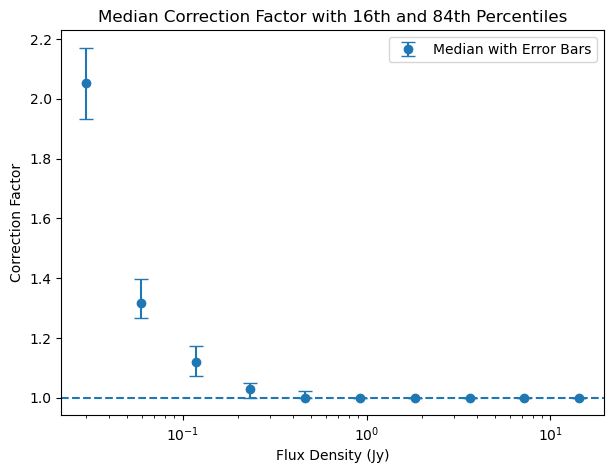

In [10]:
import numpy as np
import matplotlib.pyplot as plt
a1 = 0

# Plot with error bars
plt.figure(figsize=(7, 5))
plt.errorbar(bin_centers[a1:], correction_factor_med[a1:], 
             yerr=[correction_factor_low[a1:], correction_factor_upp[a1:]], 
             fmt='o', capsize=5, label="Median with Error Bars")

# Set log scale for x-axis
plt.xscale("log")
plt.axhline(1.0, ls='--')
# Labels and title
plt.xlabel("Flux Density (Jy)")
plt.ylabel("Correction Factor")
plt.title("Median Correction Factor with 16th and 84th Percentiles")

# Show legend
plt.legend()

# Show plot
plt.show()


In [11]:
np.savez(output_npz, 
         bin_centers = bin_centers,
         med=correction_factor_med, 
         low=correction_factor_low, 
         upp=correction_factor_upp)


# visibility area correction

In [12]:
rms_fits_file = inputimage.replace(".fits", ".pybdsf_rms.fits") 
total_valid_area, effective_image_area = dnds.visibility_function(flux_bins, 5, rms_fits_file)
print(effective_image_area)

np.savez('visibility_area_correction.npz', total=total_valid_area, effective=effective_image_area)


[0.00739694 0.00994466 0.01061838 0.01062549 0.01062556 0.01062556
 0.01062556 0.01062556 0.01062556 0.01062556]


In [13]:
# data = np.load('visibility_area_correction.npz')
# total_valid_area = data['total']
# effective_image_area = data['effective']
# print(effective_image_area)